# CNN Code Big Data Programming Project

## 1. Importing Libraries

In [4]:
import tensorflow as tf
import os
import shutil
import random
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

## 2. Training, Test and Validation dataset

In [8]:
# Root data directory
data_dir = r"Data"

# Define split ratios
train_ratio = 0.60
test_ratio = 0.25
val_ratio = 0.15

# Number of images per class
num_images_per_class = 400

In [9]:
# Output directories
output_dir = "Processed_Data"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

# Function to clear directories before adding new files
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove entire directory
    os.makedirs(directory)  # Recreate empty directory

# Create directories
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Clear and recreate directories
for folder in [train_dir, val_dir, test_dir]:
    clear_directory(folder)

In [10]:
# Loop through each emotion folder
for emotion in os.listdir(data_dir):
    emotion_path = os.path.join(data_dir, emotion)
    if not os.path.isdir(emotion_path):
        continue  # Skip if it's not a folder
    
    # Collect all image files
    images = [f for f in os.listdir(emotion_path) if f.endswith((".jpg", ".png"))]
    
    # Ensure we have the specified number of images
    images = images[:num_images_per_class]
    random.shuffle(images)
    
    # Split data
    train_files, temp_files = train_test_split(images, train_size=train_ratio, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)
    
    # Function to move files
    def move_files(file_list, src_folder, dst_folder):
        dst_folder = os.path.join(dst_folder, emotion)
        os.makedirs(dst_folder, exist_ok=True)
        for file in file_list:
            shutil.copy(os.path.join(src_folder, file), os.path.join(dst_folder, file))

    # Move files into respective directories
    move_files(train_files, emotion_path, train_dir)
    move_files(val_files, emotion_path, val_dir)
    move_files(test_files, emotion_path, test_dir)

print("Data has been split and stored in:", output_dir)


Data has been split and stored in: Processed_Data


In [11]:
#How can I get the data
train_data = r"Processed_Data\train"
valid_data = r"Processed_Data\val"
test_data = r"Processed_Data\test"

In [12]:
#not all of them have the same height & width
img_height, img_width = (224, 224)
batch_size = 32

## 3. Preprocessing

In [14]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 1200 images belonging to 5 classes.


In [15]:
test_generator = datagen.flow_from_directory(
    test_data,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical')

Found 500 images belonging to 5 classes.


In [16]:
valid_generator = datagen.flow_from_directory(
    valid_data,
    target_size=(img_height, img_width),
    batch_size=4,
    class_mode='categorical',
    shuffle=True)

Found 300 images belonging to 5 classes.


## 4. CNN Model 

In [18]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5) (x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5) (x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

#for layer in base_model.layers:
    #layer.trainable = False

In [19]:
#Change Learning Rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, start_from_epoch=10)

In [20]:
#change parameters
model.fit(train_generator, epochs = 40, validation_data = valid_generator, callbacks=[early_stopping])

C:\Users\Kim_W\BDP_Code\BDP_Project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 638s 13s/step - accuracy: 0.2487 - loss: 1.9368 - val_accuracy: 0.2267 - val_loss: 1.6770
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 494s 13s/step - accuracy: 0.2467 - loss: 1.7709 - val_accuracy: 0.2800 - val_loss: 1.5883
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 501s 13s/step - accuracy: 0.3021 - loss: 1.6060 - val_accuracy: 0.3800 - val_loss: 1.4908
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 496s 13s/step - accuracy: 0.3726 - loss: 1.5037 - val_accuracy: 0.4333 - val_loss: 1.3913
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 501s 13s/step - accuracy: 0.4094 - loss: 1.3886 - val_accuracy: 0.5100 - val_loss: 1.3017
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 503s 13s/step - accuracy: 0.5132 - loss: 1.2171 - val_accuracy: 0.5400 - val_loss: 1.2137
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 550s 13s/step - accuracy: 0.5429 - loss: 1.1684 - val_accuracy: 0.5867 - val_loss: 1.1297
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 503s 13s/step - accuracy: 0.6096 - loss: 1.0063 - val_accuracy: 0.

In [21]:
#change the model save path
model.save(os.path.join('models', 'ResNet50_pictures.h5'))

## 5. Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

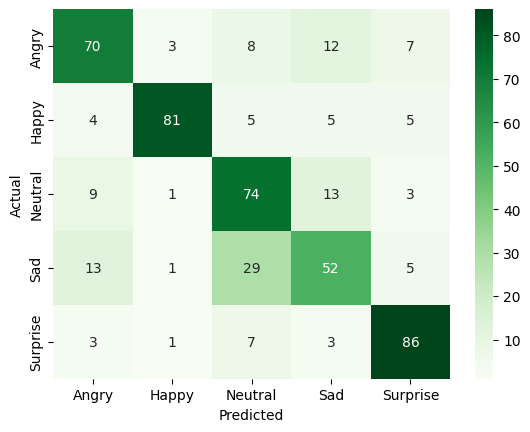

test accuracy: 72.6


In [23]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model(r"models\ResNet50_pictures.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob = []
y_act = []
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test = next(test_generator)
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Greens', annot=True, fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))